<a id="1"></a>
# Introduction

In [1]:
# The following is necessary if you want to use the fast tokenizer for deberta v2 or v3
import shutil
from pathlib import Path

transformers_path = Path("/root/miniconda3/lib/python3.8/site-packages/transformers")

input_dir = Path("deberta-v2-3-fast-tokenizer")


convert_file = input_dir / "convert_slow_tokenizer.py"
conversion_path = transformers_path/convert_file.name

if conversion_path.exists():
    conversion_path.unlink()

shutil.copy(convert_file, transformers_path)
deberta_v2_path = transformers_path / "models" / "deberta_v2"

for filename in ['tokenization_deberta_v2.py', 'tokenization_deberta_v2_fast.py', "deberta__init__.py"]:
    if str(filename).startswith("deberta"):
        filepath = deberta_v2_path/str(filename).replace("deberta", "")
    else:
        filepath = deberta_v2_path/filename
    if filepath.exists():
        filepath.unlink()

    shutil.copy(input_dir/filename, filepath)
    
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [2]:
import os
import spacy
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


tokenizers.__version__: 0.12.1
transformers.__version__: 4.17.0
env: TOKENIZERS_PARALLELISM=true


In [4]:
train = pd.read_csv("nbme-score-clinical-patient-notes/train.csv")
test = pd.read_csv("nbme-score-clinical-patient-notes/test.csv")
features = pd.read_csv("nbme-score-clinical-patient-notes/features.csv")
patient_notes = pd.read_csv("nbme-score-clinical-patient-notes/patient_notes.csv")
submission = pd.read_csv("nbme-score-clinical-patient-notes/sample_submission.csv")

warnings.filterwarnings('ignore')

# EDA

<a id="3.1"></a>
## Train data

In [5]:
print(f'\033[92mNumber of rows in train data: {train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {train.shape[1]}')
print(f'\033[91mNumber of values in train data: {train.count().sum()}')
print(f'\033[91mNumber missing values in train data: {sum(train.isna().sum())}')
train.head()

Number of rows in train data: 14300
Number of columns in train data: 6
Number of values in train data: 85800
Number missing values in train data: 0


,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


## Patient Notes Data
<a id="3.3"></a>

In [7]:
print(f'\033[92mNumber of rows in test data: {patient_notes.shape[0]}')
print(f'\033[94mNumber of columns in test data: {patient_notes.shape[1]}')
print(f'\033[91mNumber of values in train data: {patient_notes.count().sum()}')
patient_notes.head()

Number of rows in test data: 42146
Number of columns in test data: 3
Number of values in train data: 126438


,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


### Sample Patient Note 

In [8]:
print(patient_notes["pn_history"].iloc[0])

17-year-old male, has come to the student health clinic complaining of heart pounding. Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment
-began 2-3 months ago,sudden,intermittent for 2 days(lasting 3-4 min),worsening,non-allev/aggrav
-associated with dispnea on exersion and rest,stressed out about school
-reports fe feels like his heart is jumping out of his chest
-ros:denies chest pain,dyaphoresis,wt loss,chills,fever,nausea,vomiting,pedal edeam
-pmh:non,meds :aderol (from a friend),nkda
-fh:father had MI recently,mother has thyroid dz
-sh:non-smoker,mariguana 5-6 months ago,3 beers on the weekend, basketball at school
-sh:no std


### Patient Notes Distribution ( Per case ) 
<a id="3.3.1"></a>

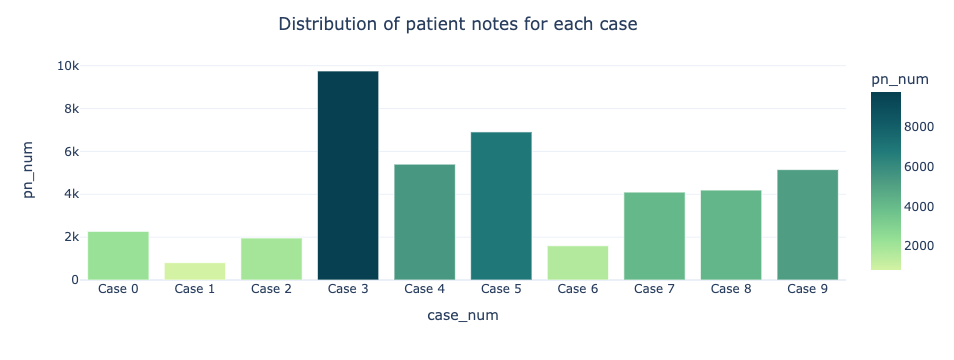

In [11]:
notes_counts = patient_notes.groupby("case_num").count()
fig = px.bar(data_frame =notes_counts, 
             x = notes_counts.index,
             y = 'pn_num' , 
             color = "pn_num",
             color_continuous_scale="Emrld") 
fig.update_layout(title = {
        'text': 'Distribution of patient notes for each case',
        'y':0.95,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'} ,
                   xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1,2, 3, 4,5, 6,7,8,9],
        ticktext = ['Case 0', 'Case 1', 'Case 2', 'Case 3', 'Case 4', 'Case 5', 'Case 6', 'Case 7', 'Case 8', 'Case 9']),
                  template = "plotly_white")
fig.show()

In [12]:
features[features['case_num']==3]

,feature_num,case_num,feature_text
43,300,3,FHx-of-PUD-OR-Family-history-of-peptic-ulcer-d...
44,301,3,Epigastric-discomfort
45,302,3,Darker-bowel-movements
46,303,3,NSAID-use-OR-Nonsteroidal-anti-inflammatory-dr...
47,304,3,burning-OR-gnawing-OR-burning-and-gnawing
48,305,3,Post-prandial-bloating-OR-fullness-with-meals
49,306,3,getting-worse-OR-progressive-OR-symptoms-now-d...
50,307,3,2-to-3-beers-a-week
51,308,3,Male
52,309,3,duration-2-months


### Patient Notes Length Distribution 
<a id="3.3.2"></a>

Average length of Patient History -  818.1768139325203


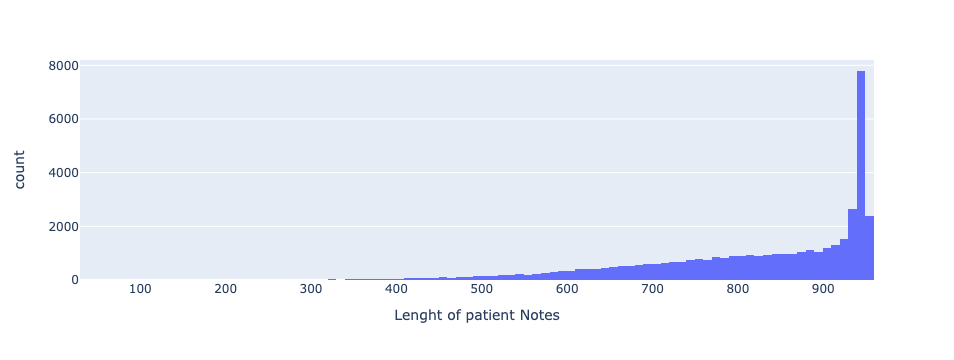

In [13]:
all_notes = []
all_notes_len = []
for notes in patient_notes['pn_history']:
    all_notes.append(notes)
    all_notes_len.append(len(notes))
print("Average length of Patient History - ",np.mean(all_notes_len))
fig = px.histogram(x = all_notes_len,nbins = 100)
fig.update_xaxes(title = "Lenght of patient Notes")
fig.show()

## Features Data
<a id="3.4"></a>

In [14]:
print(f'\033[92mNumber of rows in test data: {features.shape[0]}')
print(f'\033[94mNumber of columns in test data: {features.shape[1]}')
print(f'\033[91mNumber of values in train data: {features.count().sum()}')
features.head()

Number of rows in test data: 143
Number of columns in test data: 3
Number of values in train data: 429


,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


### Sample Feature text

In [15]:
features["feature_text"].iloc[0]

'Family-history-of-MI-OR-Family-history-of-myocardial-infarction'

## Feature Distribution (per Case) 
<a id="3.4.1"></a>

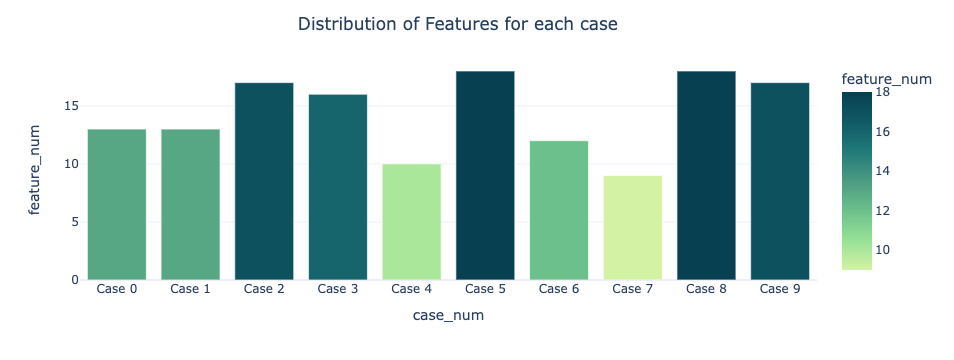

In [16]:
feature_counts = features.groupby("case_num").count()
fig = px.bar(data_frame =feature_counts, 
             x = feature_counts.index,
             y = 'feature_num' , 
             color = "feature_num",
             color_continuous_scale="Emrld") 
fig.update_layout(title = {
        'text': 'Distribution of Features for each case',
        'y':0.95,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'} ,
                   xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1,2, 3, 4,5, 6,7,8,9],
        ticktext = ['Case 0', 'Case 1', 'Case 2', 'Case 3', 'Case 4', 'Case 5', 'Case 6', 'Case 7', 'Case 8', 'Case 9']),
                  template = "plotly_white")
fig.show()

## Feature Length Distribution 
<a id="3.4.2"></a>

Average length of Features -  23.20979020979021


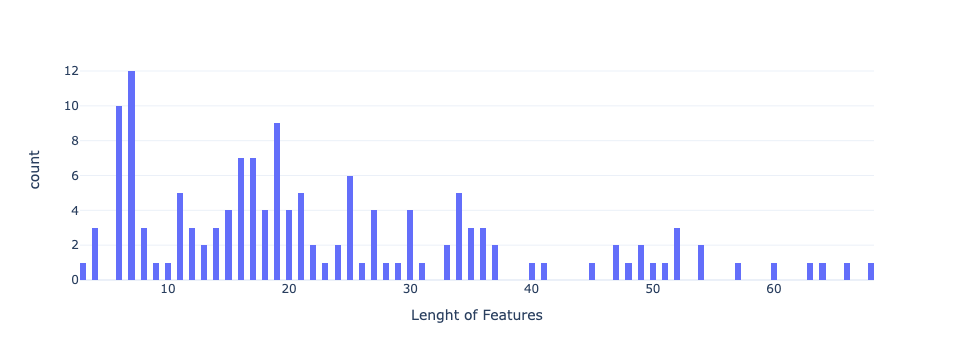

In [17]:
all_feat = []
all_feat_len = []
for notes in features['feature_text']:
    all_feat.append(notes)
    all_feat_len.append(len(notes))
print("Average length of Features - ",np.mean(all_feat_len))
fig = px.histogram(x = all_feat_len,nbins = 200)
fig.update_layout(template="plotly_white")
fig.update_xaxes(title = "Lenght of Features")
fig.show()

### Empty Annotation count

In [18]:
print("Number of Empty annotions and locations = ", sum(train["location"] == '[]'))

Number of Empty annotions and locations =  4399


### Annotation Count Distribution
<a id="3.6.1"></a>

In [ ]:
train["location"] = train["location"].apply(eval)
train['annotation'] = train['annotation'].apply(eval)
train["annot_count"] = 0
for i in range(len(train)):
    train["annot_count"][i] = len(train["annotation"][i])
total_annot = 0
for idx in train["annot_count"].value_counts().sort_index().index:
    total_annot += train["annot_count"].value_counts().sort_index()[idx] * idx
print(f'\033[92mTotal number of Annotations is train data  : ' , total_annot)
print(f'\033[94mAnnotation count per row: ')
print(f'\033[94m',train["annot_count"].value_counts().sort_index())

In [ ]:
fig = px.bar(data_frame =train, 
             x = train["annot_count"].value_counts().sort_index().index,
             y = train["annot_count"].value_counts().sort_index() , 
             color = train["annot_count"].value_counts().sort_index(),
             color_continuous_scale="Emrld") 
fig.update_xaxes(title ="Number of Annotations")
fig.update_yaxes(title ="Number of Rows")
fig.update_layout(title = {
        'text': 'Number of Annotations per row',
        'y':0.95,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'} ,
                   
                  template = "plotly_white")
fig.show()

### Annotation Length Distribution 
<a id="3.6.2"></a>

In [18]:
annot_lengths = []
all_annot_words = []
for annot in train["annotation"]:
    for words in annot:
        annot_lengths.append(len(words))
        all_annot_words.append(words)
print("Average length of Annotations - ",np.mean(annot_lengths))
fig = px.histogram(x = annot_lengths,nbins = 300)
fig.update_layout(template="plotly_white")
fig.update_xaxes(title = "Lenght of Annotation")
fig.show()

# Baseline

In [19]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    apex=False
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0.1
    epochs=3
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=4
    fc_dropout=0.2
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=500
    seed=6001
    n_fold=5
    trn_fold=[0,]
    train=True
    
if CFG.debug:
    CFG.epochs = 5
    CFG.trn_fold = [0,1,2,3,4]

## Score Functions

In [20]:
model = AutoModel.from_pretrained('microsoft/deberta-v3-large')

In [21]:
model.save_pretrained('./')

In [22]:
# Fromsave_pretrained/www.kaggle.com/theoviel/evaluation-metric-folds-baseline

def micro_f1(preds, truths):
    """
    Micro f1 on binary arrays.

    Args:
        preds (list of lists of ints): Predictions.
        truths (list of lists of ints): Ground truths.

    Returns:
        float: f1 score.
    """
    # Micro : aggregating over all instances
    preds = np.concatenate(preds)
    truths = np.concatenate(truths)
    return f1_score(truths, preds)


def spans_to_binary(spans, length=None):
    """
    Converts spans to a binary array indicating whether each character is in the span.

    Args:
        spans (list of lists of two ints): Spans.

    Returns:
        np array [length]: Binarized spans.
    """
    length = np.max(spans) if length is None else length
    binary = np.zeros(length)
    for start, end in spans:
        binary[start:end] = 1
    return binary


def span_micro_f1(preds, truths):
    """
    Micro f1 on spans.

    Args:
        preds (list of lists of two ints): Prediction spans.
        truths (list of lists of two ints): Ground truth spans.

    Returns:
        float: f1 score.
    """
    bin_preds = []
    bin_truths = []
    for pred, truth in zip(preds, truths):
        if not len(pred) and not len(truth):
            continue
        length = max(np.max(pred) if len(pred) else 0, np.max(truth) if len(truth) else 0)
        bin_preds.append(spans_to_binary(pred, length))
        bin_truths.append(spans_to_binary(truth, length))
    return micro_f1(bin_preds, bin_truths)

## Helper functions

In [23]:
def create_labels_for_scoring(df):
    # example: ['0 1', '3 4'] -> ['0 1; 3 4']
    df['location_for_create_labels'] = [ast.literal_eval(f'[]')] * len(df)
    for i in range(len(df)):
        lst = df.loc[i, 'location']
        if lst:
            new_lst = ';'.join(lst)
            df.loc[i, 'location_for_create_labels'] = ast.literal_eval(f'[["{new_lst}"]]')
    # create labels
    truths = []
    for location_list in df['location_for_create_labels'].values:
        truth = []
        if len(location_list) > 0:
            location = location_list[0]
            for loc in [s.split() for s in location.split(';')]:
                start, end = int(loc[0]), int(loc[1])
                truth.append([start, end])
        truths.append(truth)
    return truths


def get_char_probs(texts, predictions, tokenizer):
    results = [np.zeros(len(t)) for t in texts]
    for i, (text, prediction) in enumerate(zip(texts, predictions)):
        encoded = tokenizer(text, 
                            add_special_tokens=True,
                            return_offsets_mapping=True)
        for idx, (offset_mapping, pred) in enumerate(zip(encoded['offset_mapping'], prediction)):
            start = offset_mapping[0]
            end = offset_mapping[1]
            results[i][start:end] = pred
    return results


def get_results(char_probs, th=0.5):
    results = []
    for char_prob in char_probs:
        result = np.where(char_prob >= th)[0] + 1
        result = [list(g) for _, g in itertools.groupby(result, key=lambda n, c=itertools.count(): n - next(c))]
        result = [f"{min(r)} {max(r)}" for r in result]
        result = ";".join(result)
        results.append(result)
    return results


def get_predictions(results):
    predictions = []
    for result in results:
        prediction = []
        if result != "":
            for loc in [s.split() for s in result.split(';')]:
                start, end = int(loc[0]), int(loc[1])
                prediction.append([start, end])
        predictions.append(prediction)
    return predictions

# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = span_micro_f1(y_true, y_pred)
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=CFG.seed)

## Load Data

In [24]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv('../input/nbme-score-clinical-patient-notes/train.csv')
train['annotation'] = train['annotation'].apply(ast.literal_eval)
train['location'] = train['location'].apply(ast.literal_eval)
features = pd.read_csv('../input/nbme-score-clinical-patient-notes/features.csv')
def preprocess_features(features):
    features.loc[27, 'feature_text'] = "Last-Pap-smear-1-year-ago"
    return features
features = preprocess_features(features)
patient_notes = pd.read_csv('../input/nbme-score-clinical-patient-notes/patient_notes.csv')

print(f"train.shape: {train.shape}")
display(train.head())
print(f"features.shape: {features.shape}")
display(features.head())
print(f"patient_notes.shape: {patient_notes.shape}")
display(patient_notes.head())

## Merge train data with patient note and features

In [25]:
train = train.merge(features, on=['feature_num', 'case_num'], how='left')
train = train.merge(patient_notes, on=['pn_num', 'case_num'], how='left')
display(train.head())

## Manually correct some annotation errors

In [26]:
# incorrect annotation
train.loc[338, 'annotation'] = ast.literal_eval('[["father heart attack"]]')
train.loc[338, 'location'] = ast.literal_eval('[["764 783"]]')

train.loc[621, 'annotation'] = ast.literal_eval('[["for the last 2-3 months"]]')
train.loc[621, 'location'] = ast.literal_eval('[["77 100"]]')

train.loc[655, 'annotation'] = ast.literal_eval('[["no heat intolerance"], ["no cold intolerance"]]')
train.loc[655, 'location'] = ast.literal_eval('[["285 292;301 312"], ["285 287;296 312"]]')

train.loc[1262, 'annotation'] = ast.literal_eval('[["mother thyroid problem"]]')
train.loc[1262, 'location'] = ast.literal_eval('[["551 557;565 580"]]')

train.loc[1265, 'annotation'] = ast.literal_eval('[[\'felt like he was going to "pass out"\']]')
train.loc[1265, 'location'] = ast.literal_eval('[["131 135;181 212"]]')

train.loc[1396, 'annotation'] = ast.literal_eval('[["stool , with no blood"]]')
train.loc[1396, 'location'] = ast.literal_eval('[["259 280"]]')

train.loc[1591, 'annotation'] = ast.literal_eval('[["diarrhoe non blooody"]]')
train.loc[1591, 'location'] = ast.literal_eval('[["176 184;201 212"]]')

train.loc[1615, 'annotation'] = ast.literal_eval('[["diarrhea for last 2-3 days"]]')
train.loc[1615, 'location'] = ast.literal_eval('[["249 257;271 288"]]')

train.loc[1664, 'annotation'] = ast.literal_eval('[["no vaginal discharge"]]')
train.loc[1664, 'location'] = ast.literal_eval('[["822 824;907 924"]]')

train.loc[1714, 'annotation'] = ast.literal_eval('[["started about 8-10 hours ago"]]')
train.loc[1714, 'location'] = ast.literal_eval('[["101 129"]]')

train.loc[1929, 'annotation'] = ast.literal_eval('[["no blood in the stool"]]')
train.loc[1929, 'location'] = ast.literal_eval('[["531 539;549 561"]]')

train.loc[2134, 'annotation'] = ast.literal_eval('[["last sexually active 9 months ago"]]')
train.loc[2134, 'location'] = ast.literal_eval('[["540 560;581 593"]]')

train.loc[2191, 'annotation'] = ast.literal_eval('[["right lower quadrant pain"]]')
train.loc[2191, 'location'] = ast.literal_eval('[["32 57"]]')

train.loc[2553, 'annotation'] = ast.literal_eval('[["diarrhoea no blood"]]')
train.loc[2553, 'location'] = ast.literal_eval('[["308 317;376 384"]]')

train.loc[3124, 'annotation'] = ast.literal_eval('[["sweating"]]')
train.loc[3124, 'location'] = ast.literal_eval('[["549 557"]]')

train.loc[3858, 'annotation'] = ast.literal_eval('[["previously as regular"], ["previously eveyr 28-29 days"], ["previously lasting 5 days"], ["previously regular flow"]]')
train.loc[3858, 'location'] = ast.literal_eval('[["102 123"], ["102 112;125 141"], ["102 112;143 157"], ["102 112;159 171"]]')

train.loc[4373, 'annotation'] = ast.literal_eval('[["for 2 months"]]')
train.loc[4373, 'location'] = ast.literal_eval('[["33 45"]]')

train.loc[4763, 'annotation'] = ast.literal_eval('[["35 year old"]]')
train.loc[4763, 'location'] = ast.literal_eval('[["5 16"]]')

train.loc[4782, 'annotation'] = ast.literal_eval('[["darker brown stools"]]')
train.loc[4782, 'location'] = ast.literal_eval('[["175 194"]]')

train.loc[4908, 'annotation'] = ast.literal_eval('[["uncle with peptic ulcer"]]')
train.loc[4908, 'location'] = ast.literal_eval('[["700 723"]]')

train.loc[6016, 'annotation'] = ast.literal_eval('[["difficulty falling asleep"]]')
train.loc[6016, 'location'] = ast.literal_eval('[["225 250"]]')

train.loc[6192, 'annotation'] = ast.literal_eval('[["helps to take care of aging mother and in-laws"]]')
train.loc[6192, 'location'] = ast.literal_eval('[["197 218;236 260"]]')

train.loc[6380, 'annotation'] = ast.literal_eval('[["No hair changes"], ["No skin changes"], ["No GI changes"], ["No palpitations"], ["No excessive sweating"]]')
train.loc[6380, 'location'] = ast.literal_eval('[["480 482;507 519"], ["480 482;499 503;512 519"], ["480 482;521 531"], ["480 482;533 545"], ["480 482;564 582"]]')

train.loc[6562, 'annotation'] = ast.literal_eval('[["stressed due to taking care of her mother"], ["stressed due to taking care of husbands parents"]]')
train.loc[6562, 'location'] = ast.literal_eval('[["290 320;327 337"], ["290 320;342 358"]]')

train.loc[6862, 'annotation'] = ast.literal_eval('[["stressor taking care of many sick family members"]]')
train.loc[6862, 'location'] = ast.literal_eval('[["288 296;324 363"]]')

train.loc[7022, 'annotation'] = ast.literal_eval('[["heart started racing and felt numbness for the 1st time in her finger tips"]]')
train.loc[7022, 'location'] = ast.literal_eval('[["108 182"]]')

train.loc[7422, 'annotation'] = ast.literal_eval('[["first started 5 yrs"]]')
train.loc[7422, 'location'] = ast.literal_eval('[["102 121"]]')

train.loc[8876, 'annotation'] = ast.literal_eval('[["No shortness of breath"]]')
train.loc[8876, 'location'] = ast.literal_eval('[["481 483;533 552"]]')

train.loc[9027, 'annotation'] = ast.literal_eval('[["recent URI"], ["nasal stuffines, rhinorrhea, for 3-4 days"]]')
train.loc[9027, 'location'] = ast.literal_eval('[["92 102"], ["123 164"]]')

train.loc[9938, 'annotation'] = ast.literal_eval('[["irregularity with her cycles"], ["heavier bleeding"], ["changes her pad every couple hours"]]')
train.loc[9938, 'location'] = ast.literal_eval('[["89 117"], ["122 138"], ["368 402"]]')

train.loc[9973, 'annotation'] = ast.literal_eval('[["gaining 10-15 lbs"]]')
train.loc[9973, 'location'] = ast.literal_eval('[["344 361"]]')

train.loc[10513, 'annotation'] = ast.literal_eval('[["weight gain"], ["gain of 10-16lbs"]]')
train.loc[10513, 'location'] = ast.literal_eval('[["600 611"], ["607 623"]]')

train.loc[11551, 'annotation'] = ast.literal_eval('[["seeing her son knows are not real"]]')
train.loc[11551, 'location'] = ast.literal_eval('[["386 400;443 461"]]')

train.loc[11677, 'annotation'] = ast.literal_eval('[["saw him once in the kitchen after he died"]]')
train.loc[11677, 'location'] = ast.literal_eval('[["160 201"]]')

train.loc[12124, 'annotation'] = ast.literal_eval('[["tried Ambien but it didnt work"]]')
train.loc[12124, 'location'] = ast.literal_eval('[["325 337;349 366"]]')

train.loc[12279, 'annotation'] = ast.literal_eval('[["heard what she described as a party later than evening these things did not actually happen"]]')
train.loc[12279, 'location'] = ast.literal_eval('[["405 459;488 524"]]')

train.loc[12289, 'annotation'] = ast.literal_eval('[["experienced seeing her son at the kitchen table these things did not actually happen"]]')
train.loc[12289, 'location'] = ast.literal_eval('[["353 400;488 524"]]')

train.loc[13238, 'annotation'] = ast.literal_eval('[["SCRACHY THROAT"], ["RUNNY NOSE"]]')
train.loc[13238, 'location'] = ast.literal_eval('[["293 307"], ["321 331"]]')

train.loc[13297, 'annotation'] = ast.literal_eval('[["without improvement when taking tylenol"], ["without improvement when taking ibuprofen"]]')
train.loc[13297, 'location'] = ast.literal_eval('[["182 221"], ["182 213;225 234"]]')

train.loc[13299, 'annotation'] = ast.literal_eval('[["yesterday"], ["yesterday"]]')
train.loc[13299, 'location'] = ast.literal_eval('[["79 88"], ["409 418"]]')

train.loc[13845, 'annotation'] = ast.literal_eval('[["headache global"], ["headache throughout her head"]]')
train.loc[13845, 'location'] = ast.literal_eval('[["86 94;230 236"], ["86 94;237 256"]]')

train.loc[14083, 'annotation'] = ast.literal_eval('[["headache generalized in her head"]]')
train.loc[14083, 'location'] = ast.literal_eval('[["56 64;156 179"]]')

## CV

In [27]:
train['annotation']

In [28]:
train['annotation_length'] = train['annotation'].apply(len)
display(train['annotation_length'].value_counts())

In [29]:
Fold = GroupKFold(n_splits=CFG.n_fold)
groups = train['pn_num'].values
for n, (train_index, val_index) in enumerate(Fold.split(train, train['location'], groups)):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

## DataSet and DataLoader

In [30]:
from transformers.models.deberta_v2 import DebertaV2TokenizerFast
tokenizer = DebertaV2TokenizerFast.from_pretrained(CFG.model)
#tokenizer = AutoTokenizer.from_pretrained(CFG.model)
CFG.tokenizer = tokenizer


# ====================================================
# Define max_len
# ====================================================
for text_col in ['pn_history']:
    pn_history_lengths = []
    tk0 = tqdm(patient_notes[text_col].fillna("").values, total=len(patient_notes))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        pn_history_lengths.append(length)
    LOGGER.info(f'{text_col} max(lengths): {max(pn_history_lengths)}')

for text_col in ['feature_text']:
    features_lengths = []
    tk0 = tqdm(features[text_col].fillna("").values, total=len(features))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        features_lengths.append(length)
    LOGGER.info(f'{text_col} max(lengths): {max(features_lengths)}')

CFG.max_len = max(pn_history_lengths) + max(features_lengths) + 3 # cls & sep & sep
LOGGER.info(f"max_len: {CFG.max_len}")

# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text, feature_text):
    inputs = cfg.tokenizer(text, feature_text, 
                           add_special_tokens=True,
                           max_length=CFG.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


def create_label(cfg, text, annotation_length, location_list):
    encoded = cfg.tokenizer(text,
                            add_special_tokens=True,
                            max_length=CFG.max_len,
                            padding="max_length",
                            return_offsets_mapping=True)
    offset_mapping = encoded['offset_mapping']
    ignore_idxes = np.where(np.array(encoded.sequence_ids()) != 0)[0]
    label = np.zeros(len(offset_mapping))
    label[ignore_idxes] = -1
    if annotation_length != 0:
        for location in location_list:
            for loc in [s.split() for s in location.split(';')]:
                start_idx = -1
                end_idx = -1
                start, end = int(loc[0]), int(loc[1])
                for idx in range(len(offset_mapping)):
                    if (start_idx == -1) & (start < offset_mapping[idx][0]):
                        start_idx = idx - 1
                    if (end_idx == -1) & (end <= offset_mapping[idx][1]):
                        end_idx = idx + 1
                if start_idx == -1:
                    start_idx = end_idx
                if (start_idx != -1) & (end_idx != -1):
                    label[start_idx:end_idx] = 1
    return torch.tensor(label, dtype=torch.float)


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.feature_texts = df['feature_text'].values
        self.pn_historys = df['pn_history'].values
        self.annotation_lengths = df['annotation_length'].values
        self.locations = df['location'].values

    def __len__(self):
        return len(self.feature_texts)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, 
                               self.pn_historys[item], 
                               self.feature_texts[item])
        label = create_label(self.cfg, 
                             self.pn_historys[item], 
                             self.annotation_lengths[item], 
                             self.locations[item])
        return inputs, label

## Build Model

In [31]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel(self.config)
        self.fc_dropout_0 = nn.Dropout(0.1)
        self.fc_dropout_1 = nn.Dropout(cfg.fc_dropout)
        self.fc_dropout_2 = nn.Dropout(0.3)
        self.fc_dropout_3 = nn.Dropout(0.4)
        self.fc_dropout_4 = nn.Dropout(0.5)
        self.fc = nn.Linear(self.config.hidden_size, 1)
        self._init_weights(self.fc)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        return last_hidden_states

    def forward(self, inputs):
        feature = self.feature(inputs)
        #output_0 = self.fc(self.fc_dropout_0(feature))
        output_1 = self.fc(self.fc_dropout_1(feature))
        #output_2 = self.fc(self.fc_dropout_2(feature))
        #output_3 = self.fc(self.fc_dropout_3(feature))
        #output_4 = self.fc(self.fc_dropout_4(feature))
        output = output_1 #(output_0 + output_1 + output_2 + output_3 + output_4) / 5
        return output

In [32]:
class FGM():
    """
    定义对抗训练方法FGM,对模型embedding参数进行扰动
    """
    def __init__(self, model, epsilon=0.25,):
        # BERT模型
        self.model = model
        # 求干扰时的系数值
        self.epsilon = epsilon

        self.backup = {}

    def attack(self, emb_name='word_embeddings'):
        """
        得到对抗样本
        :param emb_name:模型中embedding的参数名
        :return:
        """
        # 循环遍历模型所有参数
        for name, param in self.model.named_parameters():
            # 如果当前参数在计算中保留了对应的梯度信息，并且包含了模型中embedding的参数名
            if param.requires_grad and emb_name in name:
                # 把真实参数保存起来
                self.backup[name] = param.data.clone()
                # 对参数的梯度求范数
                norm = torch.norm(param.grad)
                # 如果范数不等于0并且norm中没有缺失值
                if norm != 0 and not torch.isnan(norm):
                    # 计算扰动，param.grad / norm=单位向量，起到了sgn(param.grad)一样的作用
                    r_at = self.epsilon * param.grad / norm
                    # 在原参数的基础上添加扰动
                    param.data.add_(r_at)

    def restore(self, emb_name='word_embeddings'):
        """
        将模型原本的参数复原
        :param emb_name:模型中embedding的参数名
        """
        # 循环遍历模型所有参数
        for name, param in self.model.named_parameters():
            # 如果当前参数在计算中保留了对应的梯度信息，并且包含了模型中embedding的参数名
            if param.requires_grad and emb_name in name:
                # 断言
                assert name in self.backup
                # 取出模型真实参数
                param.data = self.backup[name]
        # 清空self.backup
        self.backup = {}


## Train function

In [33]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        loss = torch.masked_select(loss, labels.view(-1, 1) != -1).mean()
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          lr=scheduler.get_lr()[0]))
        
    return losses.avg



def train_fn_adv(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    fgm = FGM(model)
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        loss = torch.masked_select(loss, labels.view(-1, 1) != -1).mean()
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            fgm.attack() 
            # embedding参数被修改，此时，输入序列得到的embedding表征不一样                     
            y_preds_adv = model(inputs)
            loss_adv = criterion(y_preds_adv.view(-1, 1), labels.view(-1, 1))
            loss_adv = torch.masked_select(loss_adv, labels.view(-1, 1) != -1).mean()
            # 反向传播，并在正常的grad基础上，累加对抗训练的梯度
            loss_adv.backward() 
            # 恢复embedding参数
            fgm.restore() 
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          lr=scheduler.get_lr()[0]))
        
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        loss = torch.masked_select(loss, labels.view(-1, 1) != -1).mean()
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_texts = valid_folds['pn_history'].values
    valid_labels = create_labels_for_scoring(valid_folds)
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    # calculate warm up steps
    CFG.num_warmup_steps = int(CFG.num_warmup_steps * len(train_dataset) / CFG.batch_size * CFG.epochs)
    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler=='linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler=='cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="none")
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        predictions = predictions.reshape((len(valid_folds), CFG.max_len))
        
        # scoring
        char_probs = get_char_probs(valid_texts, predictions, CFG.tokenizer)
        results = get_results(char_probs, th=0.5)
        preds = get_predictions(results)
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds[[i for i in range(CFG.max_len)]] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    del scheduler
    del optimizer
    del model
    return valid_folds



In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = create_labels_for_scoring(oof_df)
        predictions = oof_df[[i for i in range(CFG.max_len)]].values
        char_probs = get_char_probs(oof_df['pn_history'].values, predictions, CFG.tokenizer)
        results = get_results(char_probs, th=0.5)
        preds = get_predictions(results)
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
                _oof_df.to_pickle(OUTPUT_DIR+'oof_df_{}.pkl'.format(fold))
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)